## Imports

In [1]:
import xarray as xr
import xgcm
from typing import Annotated

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from xhistogram.xarray import histogram
import matplotlib.colors as colors
import cartopy.crs as ccrs
import scipy
import matplotlib.patches as patches

## Open the data

In [3]:
# data in persistent bucket
#target_url ='gs://leap-scratch/cspencerjones/hero-calc/masked_hist.zarr'



###target_url ='gs://leap-persistent/cspencerjones/hero-calc/compute/llc4320/masked_hist_48hr.zarr'
#target_url ='gs://leap-persistent/cspencerjones/hero-calc/compute/llc4320/masked_hist_renorm_48hr.zarr'

target_url ='gs://leap-persistent/cspencerjones/hero-calc/masked_hist_renorm_3hr.zarr'
#target_url2 = 'gs://leap-persistent/tomnicholas/hero-calc/compute/llc4320/vort_strain_div_histogram_coarsen_nan_padding_3_hourly.zarr'

In [4]:
hist_ds = xr.open_dataset(target_url, engine="zarr", chunks={})
#hist_ds2 = xr.open_dataset(target_url2, engine="zarr", chunks={})

In [5]:
hist_ds['histogram_vort_strain_div'].isel(time=0).nbytes / 1e9

1.678950504

In [6]:
hist_ds

<xarray.Dataset> Size: 54GB
Dimensions:                    (div_bin: 99, region: 437, time: 32,
                                vort_bin: 99, strain_bin: 49, vertices: 4)
Coordinates:
  * div_bin                    (div_bin) float64 792B -4.949 -4.848 ... 4.949
    face                       (region) int64 3kB dask.array<chunksize=(13,), meta=np.ndarray>
    i_region_coarse            (region) int64 3kB dask.array<chunksize=(437,), meta=np.ndarray>
    j_region_coarse            (region) int64 3kB dask.array<chunksize=(437,), meta=np.ndarray>
    region_num                 (region) int64 3kB dask.array<chunksize=(437,), meta=np.ndarray>
  * strain_bin                 (strain_bin) float64 392B 0.05102 ... 4.949
  * time                       (time) datetime64[ns] 256B 2011-09-17 ... 2012...
    vertices_latitude          (vertices, region) float32 7kB dask.array<chunksize=(4, 437), meta=np.ndarray>
    vertices_longitude         (vertices, region) float32 7kB dask.array<chunksize=(4, 437), meta=np.ndarray>
  * vort_bin                   (vort_bin) float64 792B -4.949 -4.848 ... 4.949
Dimensions without coordinates: region, vertices
Data variables:
    histogram_vort_strain_div  (time, region, vort_bin, strain_bin, div_bin) float64 54GB dask.array<chunksize=(1, 1, 99, 49, 99), meta=np.ndarray>

In [7]:
from xarray.indexes import PandasIndex

# have to add the index ourselves manually for some reason
hist_ds = hist_ds.set_xindex('region_num', PandasIndex)
#hist_ds2 = hist_ds2.set_xindex('region_num', PandasIndex)

/tmp/ipykernel_205/2510200718.py:34: RuntimeWarning: invalid value encountered in divide
  u_diff_x = (u[..., 1:] - u[..., :-1]) / dxc[..., 1:]
/tmp/ipykernel_205/2510200718.py:35: RuntimeWarning: invalid value encountered in divide
  v_diff_x = (v[..., 1:] - v[..., :-1]) / dxc[..., 1:]
/tmp/ipykernel_205/2510200718.py:36: RuntimeWarning: invalid value encountered in divide
  u_diff_y = (u[..., 1:, :] - u[..., :-1, :]) / dyc[..., 1:, :]
/tmp/ipykernel_205/2510200718.py:37: RuntimeWarning: invalid value encountered in divide
  v_diff_y = (v[..., 1:, :] - v[..., :-1, :]) / dyc[..., 1:, :]
/tmp/ipykernel_205/2510200718.py:34: RuntimeWarning: invalid value encountered in divide
  u_diff_x = (u[..., 1:] - u[..., :-1]) / dxc[..., 1:]
/tmp/ipykernel_205/2510200718.py:35: RuntimeWarning: invalid value encountered in divide
  v_diff_x = (v[..., 1:] - v[..., :-1]) / dxc[..., 1:]
/tmp/ipykernel_205/2510200718.py:36: RuntimeWarning: invalid value encountered in divide
  u_diff_y = (u[..., 1:, :] -

In [8]:
hist_ds

<xarray.Dataset> Size: 54GB
Dimensions:                    (div_bin: 99, region: 437, time: 32,
                                vort_bin: 99, strain_bin: 49, vertices: 4)
Coordinates:
  * div_bin                    (div_bin) float64 792B -4.949 -4.848 ... 4.949
    face                       (region) int64 3kB dask.array<chunksize=(13,), meta=np.ndarray>
    i_region_coarse            (region) int64 3kB dask.array<chunksize=(437,), meta=np.ndarray>
    j_region_coarse            (region) int64 3kB dask.array<chunksize=(437,), meta=np.ndarray>
  * region_num                 (region) int64 3kB 4 5 6 7 13 ... 792 793 798 799
  * strain_bin                 (strain_bin) float64 392B 0.05102 ... 4.949
  * time                       (time) datetime64[ns] 256B 2011-09-17 ... 2012...
    vertices_latitude          (vertices, region) float32 7kB dask.array<chunksize=(4, 437), meta=np.ndarray>
    vertices_longitude         (vertices, region) float32 7kB dask.array<chunksize=(4, 437), meta=np.ndarray>
  * vort_bin                   (vort_bin) float64 792B -4.949 -4.848 ... 4.949
Dimensions without coordinates: region, vertices
Data variables:
    histogram_vort_strain_div  (time, region, vort_bin, strain_bin, div_bin) float64 54GB dask.array<chunksize=(1, 1, 99, 49, 99), meta=np.ndarray>

## Correct PDF normalization

Division by 80 comes from 8 samples per day (3-hourly sampling of hourly data) over a 10-day period. 
This correction is currently required because I accidentally did `coarsen(time=8*10).sum(dim='time')` instead of `coarsen(time=8*10).mean(dim='time')` before saving to zarr.

In [9]:
#hist_ds2['histogram_vort_strain_div'] = hist_ds2['histogram_vort_strain_div'] / 80

In [10]:
hist_ds['histogram_vort_strain_div'].isel(time=slice(11,20)).time

<xarray.DataArray 'time' (time: 9)> Size: 72B
array(['2012-01-05T00:00:00.000000000', '2012-01-15T00:00:00.000000000',
       '2012-01-25T00:00:00.000000000', '2012-02-04T00:00:00.000000000',
       '2012-02-14T00:00:00.000000000', '2012-02-24T00:00:00.000000000',
       '2012-03-05T00:00:00.000000000', '2012-03-15T00:00:00.000000000',
       '2012-03-25T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 72B 2012-01-05 2012-01-15 ... 2012-03-25

## Basic quantities

In [11]:
#JFM
h = hist_ds['histogram_vort_strain_div'].isel(time=slice(11,20))
h['center_lat'] = hist_ds.vertices_latitude.mean('vertices')
h['center_lon'] = hist_ds.vertices_longitude.mean('vertices')
max_vert = abs(hist_ds.vertices_longitude.diff('vertices')).max('vertices')
h['center_lon'] = h['center_lon'].where(max_vert<100,((hist_ds.vertices_longitude.where(max_vert>100).min('vertices') +hist_ds.vertices_longitude.where(max_vert>100).max('vertices')+360)/2))
h1 = h.mean('time')
h_gt_val = h1.where((h1.strain_bin>2) & (h1.vort_bin<0.5)& (h1.vort_bin>-0.5)).sum('strain_bin').sum('vort_bin').sum('div_bin')
div_2d = ((h1.div_bin*h1).mean('div_bin')/970)
div_gt_val = div_2d.where((div_2d.strain_bin>3) & (h1.vort_bin>1)).sum('strain_bin').sum('vort_bin').load()


#ASO
h_ASO = hist_ds['histogram_vort_strain_div'].roll(time=5,roll_coords=True).isel(time=slice(0,10))
h_ASO['center_lat'] = hist_ds.vertices_latitude.mean('vertices')
h_ASO['center_lon'] = hist_ds.vertices_longitude.mean('vertices')
max_vert = abs(hist_ds.vertices_longitude.diff('vertices')).max('vertices')
h_ASO['center_lon'] = h['center_lon'].where(max_vert<100,((hist_ds.vertices_longitude.where(max_vert>100).min('vertices') +hist_ds.vertices_longitude.where(max_vert>100).max('vertices')+360)/2))
h1_ASO = h_ASO.mean('time')
h_gt_val_ASO = h1_ASO.where((h1_ASO.strain_bin>2) & (h1_ASO.vort_bin<0.5)& (h1_ASO.vort_bin>-0.5)).sum('strain_bin').sum('vort_bin').sum('div_bin')
div_2d_ASO = ((h1_ASO.div_bin*h1_ASO).mean('div_bin')/970)
div_gt_val_ASO = div_2d_ASO.where((div_2d_ASO.strain_bin>3) & (h1_ASO.vort_bin>1)).sum('strain_bin').sum('vort_bin').load()

/tmp/ipykernel_205/2510200718.py:34: RuntimeWarning: invalid value encountered in divide
  u_diff_x = (u[..., 1:] - u[..., :-1]) / dxc[..., 1:]
/tmp/ipykernel_205/2510200718.py:35: RuntimeWarning: invalid value encountered in divide
  v_diff_x = (v[..., 1:] - v[..., :-1]) / dxc[..., 1:]
/tmp/ipykernel_205/2510200718.py:36: RuntimeWarning: invalid value encountered in divide
  u_diff_y = (u[..., 1:, :] - u[..., :-1, :]) / dyc[..., 1:, :]
/tmp/ipykernel_205/2510200718.py:37: RuntimeWarning: invalid value encountered in divide
  v_diff_y = (v[..., 1:, :] - v[..., :-1, :]) / dyc[..., 1:, :]
/tmp/ipykernel_205/2510200718.py:34: RuntimeWarning: invalid value encountered in divide
  u_diff_x = (u[..., 1:] - u[..., :-1]) / dxc[..., 1:]
/tmp/ipykernel_205/2510200718.py:35: RuntimeWarning: invalid value encountered in divide
  v_diff_x = (v[..., 1:] - v[..., :-1]) / dxc[..., 1:]
/tmp/ipykernel_205/2510200718.py:36: RuntimeWarning: invalid value encountered in divide
  u_diff_y = (u[..., 1:, :] -

<>:25: SyntaxWarning: invalid escape sequence '\z'
<>:46: SyntaxWarning: invalid escape sequence '\z'
<>:25: SyntaxWarning: invalid escape sequence '\z'
<>:46: SyntaxWarning: invalid escape sequence '\z'
/tmp/ipykernel_205/610844888.py:25: SyntaxWarning: invalid escape sequence '\z'
  plt.title('Jan/Feb/Mar mean divergence for \n cells with $\zeta$>$f_{floor}$ and $\sigma$>3$|f_{floor}|$')
/tmp/ipykernel_205/610844888.py:46: SyntaxWarning: invalid escape sequence '\z'
  plt.title('Aug/Sept/Oct mean divergence for \n cells with $\zeta$>$f_{floor}$ and $\sigma$>3$|f_{floor}|$')


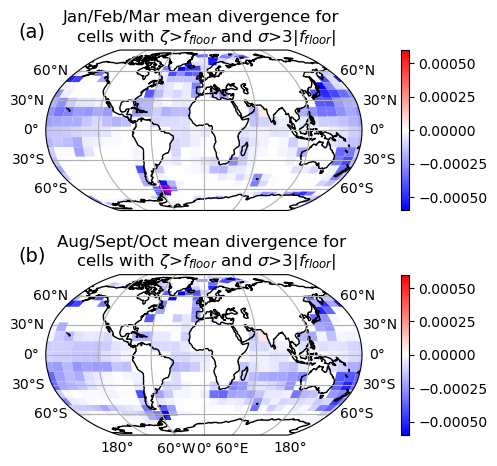

In [12]:
fig = plt.figure(figsize=(10, 5))
plt.clf()
ax = fig.add_subplot(2, 1, 1, projection=ccrs.Robinson())

ax.set_global()

ax.coastlines()


from matplotlib.collections import PolyCollection
#fig, ax = plt.subplots()
max_vert = abs(hist_ds.vertices_longitude.diff('vertices')).max('vertices')
hist_ds['lon'] = hist_ds['vertices_longitude'].where((max_vert<100) | (hist_ds.vertices_longitude>-170),hist_ds.vertices_longitude.where((max_vert>100) & (hist_ds.vertices_longitude<-170))+360)
verts = np.stack((hist_ds.lon.values, hist_ds.vertices_latitude.values),2)
verts = np.swapaxes(verts, 0, 1)

# Make the collection and add it to the plot.
coll = PolyCollection(verts, array=div_gt_val, cmap='bwr', edgecolors='none', transform=ccrs.PlateCarree())
ax.add_collection(coll)
coll.set_clim(vmin=-0.0006,vmax=0.0006)
ax.autoscale_view
plt.colorbar(coll)
ax.gridlines(draw_labels=["left", "right"])
plt.text(-2*10**7,10**7,'(a)',fontsize=14)
plt.title('Jan/Feb/Mar mean divergence for \n cells with $\zeta$>$f_{floor}$ and $\sigma$>3$|f_{floor}|$')

col2 = PolyCollection(verts[416:417], array=div_gt_val[416:417], facecolors='none', linewidths=2, edgecolors='m', transform=ccrs.PlateCarree())
ax.add_collection(col2)
ax.autoscale_view()

ax2 = fig.add_subplot(2, 1, 2, projection=ccrs.Robinson())

ax2.set_global()

ax2.coastlines()


# Make the collection and add it to the plot.
coll = PolyCollection(verts, array=div_gt_val_ASO, cmap='bwr', edgecolors='none', transform=ccrs.PlateCarree())
ax2.add_collection(coll)
coll.set_clim(vmin=-0.0006,vmax=0.0006)
#ax2.autoscale_view
plt.colorbar(coll)
ax2.gridlines(draw_labels=["bottom", "left", "right"])
ax2.text(-2*10**7,10**7,'(b)',fontsize=14)
plt.title('Aug/Sept/Oct mean divergence for \n cells with $\zeta$>$f_{floor}$ and $\sigma$>3$|f_{floor}|$')

plt.subplots_adjust(hspace=0.4)
plt.savefig('hi-strain-hi-vort.png')

In [13]:
div_gt_val.where(div_gt_val<-0.0005).dropna('region').center_lat.values

array([ 62.777275,  67.72254 ,  69.36192 ,  74.23377 ,  51.689716,
        44.6715  , -53.845566, -59.78252 , -64.904366], dtype=float32)

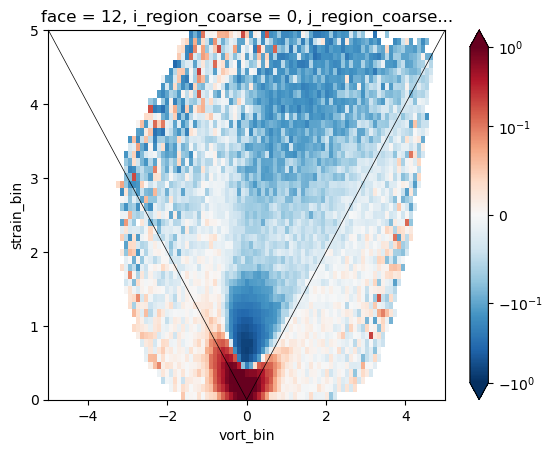

In [14]:
from matplotlib import colors as cols
h1_2d = (h1.sum('div_bin').mean('region')/970).load()
div_2d_masked = div_2d.where(h1_2d>10**-6)
(div_2d_masked*10**5).isel(region=416).plot(x='vort_bin',vmax=1, norm=cols.SymLogNorm(1e-1), extend='both', cmap='RdBu_r')
plt.plot(np.linspace(0,5), np.linspace(0,5),color='k',linewidth=0.5)
plt.plot(np.linspace(-5,0), np.linspace(5,0),color='k',linewidth=0.5)

In [15]:
h1.isel(region=416).center_lon.values

array(-54.875, dtype=float32)

In [16]:
def open_llc4320_velocity_data(chunks='auto', time_range=None):
    
    ds_SSU = xr.open_dataset(
        "gs://pangeo-ecco-llc4320/ssu", 
        engine="zarr", 
        storage_options={'requester_pays': True}, 
        chunks=chunks, 
        inline_array=True,
        consolidated=True, 
    )
    
    ds_SSV = xr.open_dataset(
        "gs://pangeo-ecco-llc4320/ssv", 
        engine="zarr", 
        storage_options={'requester_pays': True}, 
        chunks=chunks, 
        inline_array=True,
        consolidated=True, 
    )
    
    # Open grid data
    ds_grid = xr.open_dataset(
        "gs://pangeo-ecco-llc4320/grid", 
        engine="zarr", 
        storage_options={'requester_pays': True}, 
        chunks=chunks, 
        inline_array=True,
        consolidated=True, 
    )
    
    coords_to_keep = ['XC', 'YC', 'dxC', 'dyC', 'dxG', 'dyG', 'rAz', 'rA', 'Depth']
    ds_grid = ds_grid.reset_coords()[coords_to_keep]
    
    ds = xr.merge([ds_SSU, ds_SSV, ds_grid])
    
    if time_range is not None:
        ds = ds.isel(time=time_range)
        
    ds = ds.chunk(chunks)
    
    return ds, ds_grid
    

In [17]:
ds, ds_grid = open_llc4320_velocity_data(chunks={})

In [18]:
grid = xgcm.Grid(ds_grid, periodic=False)

In [19]:



@xgcm.as_grid_ufunc(
    boundary_width={"X": (1, 0), "Y": (1, 0)},
    boundary="fill",
    fill_value=np.nan,
    dask="parallelized",    
)
def vort(
    u:   Annotated[np.ndarray, "(Y:center,X:left)"],
    dxc: Annotated[np.ndarray, "(Y:center,X:left)"],
    v:   Annotated[np.ndarray, "(Y:left,X:center)"],
    dyc: Annotated[np.ndarray, "(Y:left,X:center)"],
    raz: Annotated[np.ndarray, "(Y:left,X:left)"],
) ->     Annotated[np.ndarray, "(Y:left,X:left)"]:
    """Dimensional vorticity"""
    
    u_trans = u * dxc
    v_trans = v * dyc
    v_diff_x = v_trans[..., 1:, 1:] - v_trans[..., 1:, :-1]
    u_diff_y = u_trans[..., 1:, 1:] - u_trans[..., :-1, 1:]
    return (v_diff_x - u_diff_y) / raz[..., 1:, 1:]

@xgcm.as_grid_ufunc(
    boundary_width={"X": (1, 0), "Y": (1, 0)},
    boundary="fill",
    fill_value=np.nan,
    dask="parallelized",    
)
def strain(
    u:   Annotated[np.ndarray, "(Y:center,X:left)"],
    dxc: Annotated[np.ndarray, "(Y:center,X:left)"],
    v:   Annotated[np.ndarray, "(Y:left,X:center)"],
    dyc: Annotated[np.ndarray, "(Y:left,X:center)"],
) ->     Annotated[np.ndarray, "(Y:left,X:left)"]:
    u_diff_x = (u[..., 1:] - u[..., :-1]) / dxc[..., 1:]
    v_diff_x = (v[..., 1:] - v[..., :-1]) / dxc[..., 1:]
    u_diff_y = (u[..., 1:, :] - u[..., :-1, :]) / dyc[..., 1:, :]
    v_diff_y = (v[..., 1:, :] - v[..., :-1, :]) / dyc[..., 1:, :]
    
    u_diff_x_trimmed = u_diff_x[..., 1:, :]
    v_diff_x_trimmed = v_diff_x[..., 1:, :]
    u_diff_y_trimmed = u_diff_y[..., 1:]
    v_diff_y_trimmed = v_diff_y[..., 1:]
    
    strain_normal = u_diff_x_trimmed - v_diff_y_trimmed
    strain_shear = v_diff_x_trimmed + u_diff_y_trimmed
    
    # TODO: interpolate the shear strain onto the positions of the normal strain
    # For now, we just pretend they are at the same grid point
    strain_mag = np.sqrt(strain_normal ** 2 +  strain_shear ** 2)
    
    return strain_mag

@xgcm.as_grid_ufunc(
    boundary_width={"X": (1, 0), "Y": (1, 0)},
    boundary="fill",
    fill_value=np.nan,
    dask="parallelized",
)
def divergence(
    u:   Annotated[np.ndarray, "(Y:center,X:left)"],
    dxg: Annotated[np.ndarray, "(Y:left,X:center)"],
    v:   Annotated[np.ndarray, "(Y:left,X:center)"],
    dyg: Annotated[np.ndarray, "(Y:center,X:left)"],
    ra:  Annotated[np.ndarray, "(Y:center,X:center)"],
) ->     Annotated[np.ndarray, "(Y:center,X:center)"]:
    
    u_diff_x = (u[..., 1:] - u[..., :-1]) * dxg[..., 1:]
    v_diff_y = (v[..., 1:, :] - v[..., :-1, :]) * dyg[..., 1:, :]
    
    u_diff_x_trimmed = u_diff_x[..., 1:, :]
    v_diff_y_trimmed = v_diff_y[..., 1:]
    
    divergence = (u_diff_x_trimmed + v_diff_y_trimmed) / ra[..., 1:, 1:]
    
    return divergence

In [20]:
def vort_strain_div_bins(n_strain_bins=100, n_vort_bins=200, n_div_bins=200, vort_max=5, strain_max=5, div_max=5):
    vort_bins = np.linspace(-vort_max, vort_max, n_vort_bins)
    strain_bins = np.linspace(0.0, strain_max, n_strain_bins)
    div_bins = np.linspace(-div_max, div_max, n_div_bins)
    return vort_bins, strain_bins, div_bins

In [21]:
vort_bins, strain_bins, div_bins = vort_strain_div_bins(n_strain_bins=50, n_vort_bins=100, n_div_bins=100)
a = np.diff(vort_bins)[0]*np.diff(strain_bins)[0]*np.diff(div_bins)[0]

In [22]:
ζ = vort(grid, ds.U, ds.dxC, ds.V, ds.dyC, ds.rAz, axis= 5 * [("Y", "X")])
σ = strain(grid, ds.U, ds.dxC, ds.V, ds.dyC, axis=4 * [("Y", "X")])
D = divergence(grid, ds.U, ds.dxG, ds.V, ds.dyG, ds.rA, axis= 5 * [("Y", "X")])

/srv/conda/envs/notebook/lib/python3.12/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/srv/conda/envs/notebook/lib/python3.12/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/srv/conda/envs/notebook/lib/python3.12/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in orde

In [23]:
ds.sel(face=12).isel(i_g=slice(0,550)).isel(i=slice(0,550)).isel(j_g=slice(3300,3850),j=slice(3300,3850)).XC.max().values

array(-47.802082, dtype=float32)

In [24]:
Depth_piece = ds.sel(face=12).isel(i_g=slice(0,550)).isel(i=slice(0,550)).isel(j_g=slice(3300,3850),j=slice(3300,3850)).Depth

In [25]:
#ds.isel(time=slice(4000-350, 4000+350)).time.values

In [26]:
σ_piece = σ.isel(time=4000).sel(face=12).isel(i_g=slice(0,550)).isel(j_g=slice(3300,3850)).rename({"i_g": "i", "j_g": "j"})/1.25/10**-4
ζ_piece = ζ.isel(time=4000).sel(face=12).isel(i_g=slice(0,550)).isel(j_g=slice(3300,3850)).rename({"i_g": "i", "j_g": "j"})/1.25/(-10**-4)
D_piece = D.isel(time=4000).sel(face=12).isel(i=slice(0,550)).isel(j=slice(3300,3850))/1.25/10**-4

In [27]:
σ_piece2 = σ.isel(time=np.arange(4000-350,4000+350,24)).sel(face=12).isel(i_g=slice(0,550)).isel(j_g=slice(3300,3850)).rename({"i_g": "i", "j_g": "j"})/1.25/10**-4
ζ_piece2 = ζ.isel(time=np.arange(4000-350,4000+350,24)).sel(face=12).isel(i_g=slice(0,550)).isel(j_g=slice(3300,3850)).rename({"i_g": "i", "j_g": "j"})/1.25/(-10**-4)
D_piece2 = D.isel(time=np.arange(4000-350,4000+350,24)).sel(face=12).isel(i=slice(0,550)).isel(j=slice(3300,3850))/1.25/10**-4

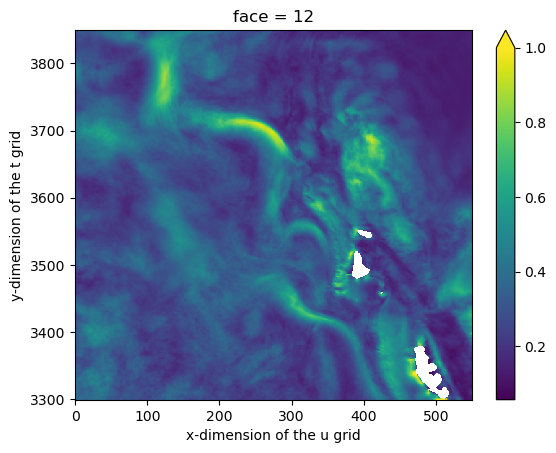

In [36]:
U2 = ds.U.isel(time=np.arange(4000-350,4000+350,24)).sel(face=12).isel(i_g=slice(0,550)).isel(j=slice(3300,3850)).rename({"i_g": "i"})
V2 = ds.V.isel(time=np.arange(4000-350,4000+350,24)).sel(face=12).isel(i=slice(0,550)).isel(j_g=slice(3300,3850)).rename({"j_g": "j"})
(np.sqrt(U2**2+V2**2)).mean('time').plot(vmax=1)

In [28]:
test2 = (D_piece2.where((σ_piece2>3))).mean('time').transpose().load()

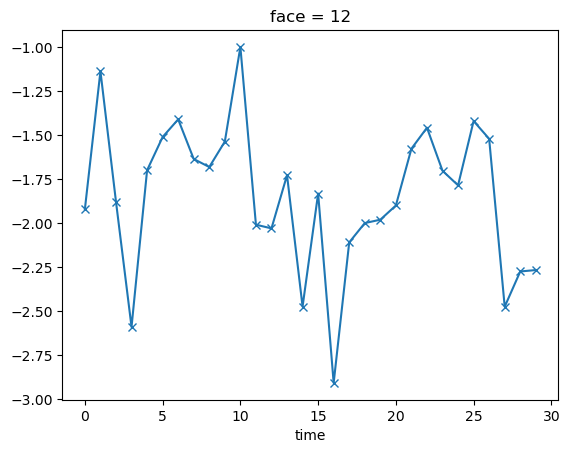

In [50]:
(D_piece2.where((σ_piece2>3))).sel(j=slice(3600,3800)).sel(i=slice(300,500)).mean(['i','j']).plot(marker='x')#['i','j']

(300.0, 500.0)

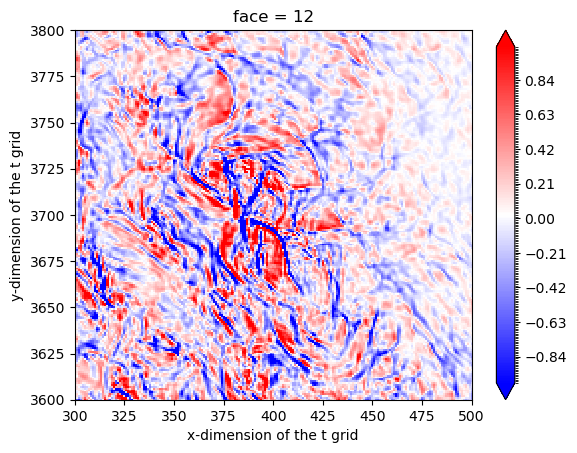

In [52]:
(D_piece2).isel(time=3).plot(levels=np.arange(-1,1.05,0.01), cmap='bwr')
plt.ylim(3600,3800)
plt.xlim(300,500)

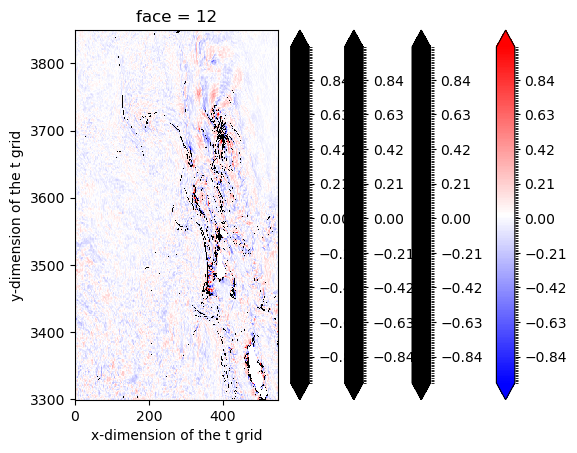

In [31]:
(D_piece2).mean('time').plot(levels=np.arange(-1,1.05,0.01), cmap='bwr')
(D_piece2.where((σ_piece2>2))).isel(time=3).plot(levels=np.arange(-1,1.05,0.01), colors='k')
(D_piece2.where((σ_piece2>2))).isel(time=13).plot(levels=np.arange(-1,1.05,0.01), colors='k')
(D_piece2.where((σ_piece2>2))).isel(time=23).plot(levels=np.arange(-1,1.05,0.01), colors='k')
#plt.ylim(3600,3800)
#plt.xlim(300,500)

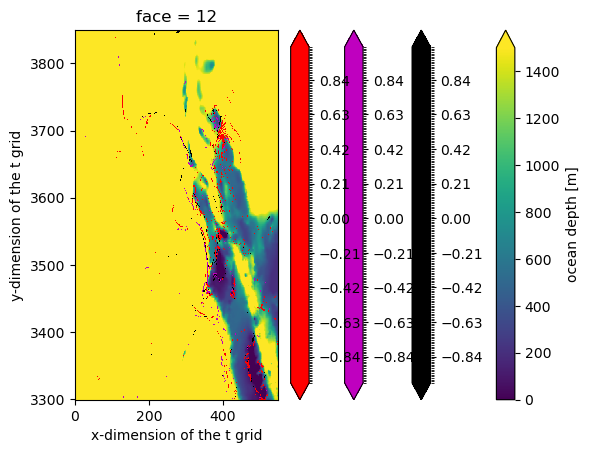

In [67]:
(Depth_piece).plot(vmax=1500)
(D_piece2.where((σ_piece2>2))).isel(time=3).plot(levels=np.arange(-1,1.05,0.01), colors='k')
(D_piece2.where((σ_piece2>2))).isel(time=13).plot(levels=np.arange(-1,1.05,0.01), colors='m')
(D_piece2.where((σ_piece2>2))).isel(time=23).plot(levels=np.arange(-1,1.05,0.01), colors='r')
#plt.ylim(3600,3800)
#plt.xlim(300,500)

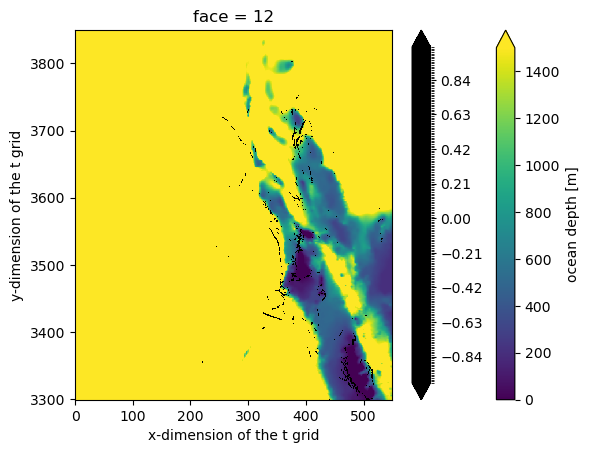

In [62]:
(Depth_piece).plot(vmax=1500)
(D_piece2.where((σ_piece2>2))).isel(time=4).plot(levels=np.arange(-1,1.05,0.01), colors='k')
#plt.ylim(3600,3800)
#plt.xlim(300,500)

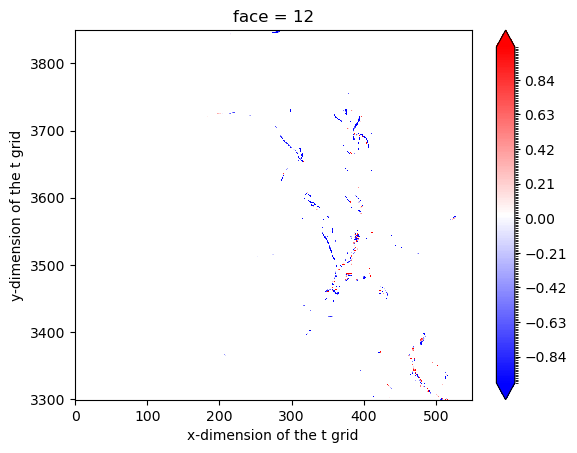

In [59]:
(D_piece2.where((σ_piece2>2))).isel(time=3).plot(levels=np.arange(-1,1.05,0.01), cmap='bwr')


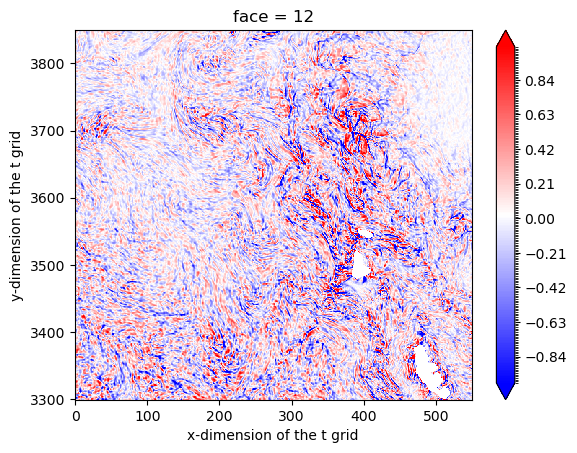

In [60]:
(D_piece2).isel(time=3).plot(levels=np.arange(-1,1.05,0.01), cmap='bwr')

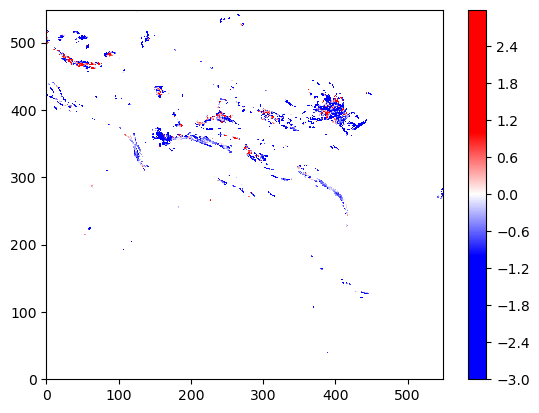

In [58]:
cs=plt.contourf(test2.values, vmin=-1, vmax=1, levels=np.arange(-3,3,0.01),cmap='bwr')
plt.colorbar(cs,extend='both')

In [59]:
h = histogram(
    ζ_piece2.rename('vort'),
    σ_piece2.rename('strain'),
    D_piece2.rename('div'),
    bins=[vort_bins, strain_bins, div_bins],
    block_size=None,  # avoids a divide-by-zero bug in xhistogram's code for automatically determining block_size
    density=False,  # setting this to true leads to an error right now
    keep_coords=True,
)
h = h/a/550/550

In [48]:
def marginalize(pdf: xr.DataArray, dims: str | list = None) -> xr.DataArray:
    """
    Integrate out one or more dimensions of the PDF to remove dependence on that quantity,
    whilst still preserving the total integrated probability.
    """
       
    all_bin_dims = ['vort_bin', 'strain_bin', 'div_bin']
    
    if isinstance(dims, str):
        dims = [dims]
    
    if dims is None:
        dims=all_bin_dims
    
    if any(d not in all_bin_dims for d in dims):
        raise ValueError("Can't take marginal PDF over a dimension which is not a variable of the original PDF")
    
    marginal_pdf = pdf

    # TODO these might be more accurate if we used xarray's integrate function
    if 'vort_bin' in dims:
        vort_bin_width = pdf['vort_bin'].diff('vort_bin')[0]
        marginal_pdf = marginal_pdf.sum(dim='vort_bin') * vort_bin_width
        
    if 'strain_bin' in dims:
        strain_bin_width = pdf['strain_bin'].diff('strain_bin')[0]
        marginal_pdf = marginal_pdf.sum(dim='strain_bin') * strain_bin_width
        
    if 'div_bin' in dims:
        div_bin_width = pdf['div_bin'].diff('div_bin')[0]
        marginal_pdf = marginal_pdf.sum(dim='div_bin') * div_bin_width
        
    return marginal_pdf

def expectation(pdf: xr.DataArray, x: xr.DataArray, dims: str | list = None) -> xr.DataArray:
    """
    Take the expectation value of x over the given Probability Density Function.
    """
    
    return marginalize(pdf * x, dims=dims)

In [49]:
@xr.register_dataarray_accessor("pdf")
class DataArrayPDFAccessor:
    def __init__(self, da: xr.DataArray):
        self._da = da
        
    def marginalize(self, dims: str | list = None) -> xr.DataArray:
        return marginalize(self._da, dims=dims)
    
    def expectation(self, x, dims: str | list = None) -> xr.DataArray:
        return expectation(self._da, x, dims=dims)

In [62]:
h_vort_strain = (h.pdf.marginalize('div_bin')/97).load()
h_DivPdf = (h*h.div_bin).mean('div_bin').load()
lat = ds.sel(face=1).YC.mean('i')
lon = ds.sel(face=1).XC.mean('j')

lon_piece = ds.sel(face=12).isel(i=slice(0,550)).isel(j=slice(3300,3850)).XC.mean('i')
lat_piece = ds.sel(face=12).isel(i=slice(0,550)).isel(j=slice(3300,3850)).YC.mean('j')

<>:7: SyntaxWarning: invalid escape sequence '\z'
<>:8: SyntaxWarning: invalid escape sequence '\s'
<>:7: SyntaxWarning: invalid escape sequence '\z'
<>:8: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_122/738368629.py:7: SyntaxWarning: invalid escape sequence '\z'
  plt.xlabel('$\zeta/f_{floor}$')
/tmp/ipykernel_122/738368629.py:8: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('$\sigma/f_{floor}$')


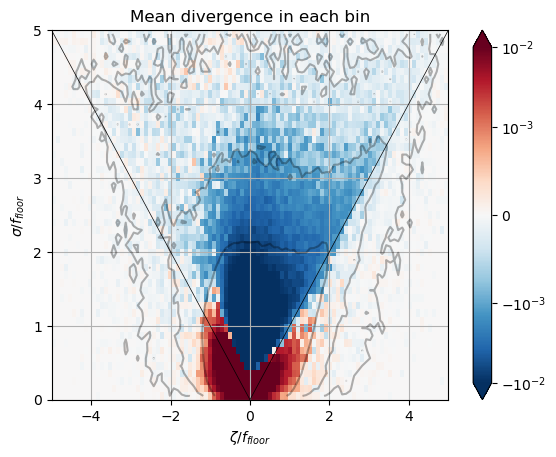

In [63]:
h_DivPdf.plot(x='vort_bin', vmax=0.01, norm=mpl.colors.SymLogNorm(1e-3))
h_vort_strain.plot.contour(x='vort_bin',levels=[1e-3, 1e-4, 1e-5], colors='k', alpha=.3)
plt.title('Mean divergence in each bin')
plt.plot(np.linspace(0,5), np.linspace(0,5),color='k',linewidth=0.5)
plt.plot(np.linspace(-5,0), np.linspace(5,0),color='k',linewidth=0.5)

plt.xlabel('$\zeta/f_{floor}$')
plt.ylabel('$\sigma/f_{floor}$')
plt.grid()

<>:17: SyntaxWarning: invalid escape sequence '\z'
<>:32: SyntaxWarning: invalid escape sequence '\z'
<>:33: SyntaxWarning: invalid escape sequence '\s'
<>:52: SyntaxWarning: invalid escape sequence '\s'
<>:17: SyntaxWarning: invalid escape sequence '\z'
<>:32: SyntaxWarning: invalid escape sequence '\z'
<>:33: SyntaxWarning: invalid escape sequence '\s'
<>:52: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_122/2446507439.py:17: SyntaxWarning: invalid escape sequence '\z'
  plt.title('$\zeta/f$ in example region')
/tmp/ipykernel_122/2446507439.py:32: SyntaxWarning: invalid escape sequence '\z'
  plt.xlabel('$\zeta/f_{floor}$')
/tmp/ipykernel_122/2446507439.py:33: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('$\sigma/f_{floor}$')
/tmp/ipykernel_122/2446507439.py:52: SyntaxWarning: invalid escape sequence '\s'
  plt.title('Divergence masked to only \n  show areas where $\sigma>3f$ \n  & $-\zeta>f$ (1 month mean)')
/tmp/ipykernel_122/2446507439.py:9: UserWarning: A

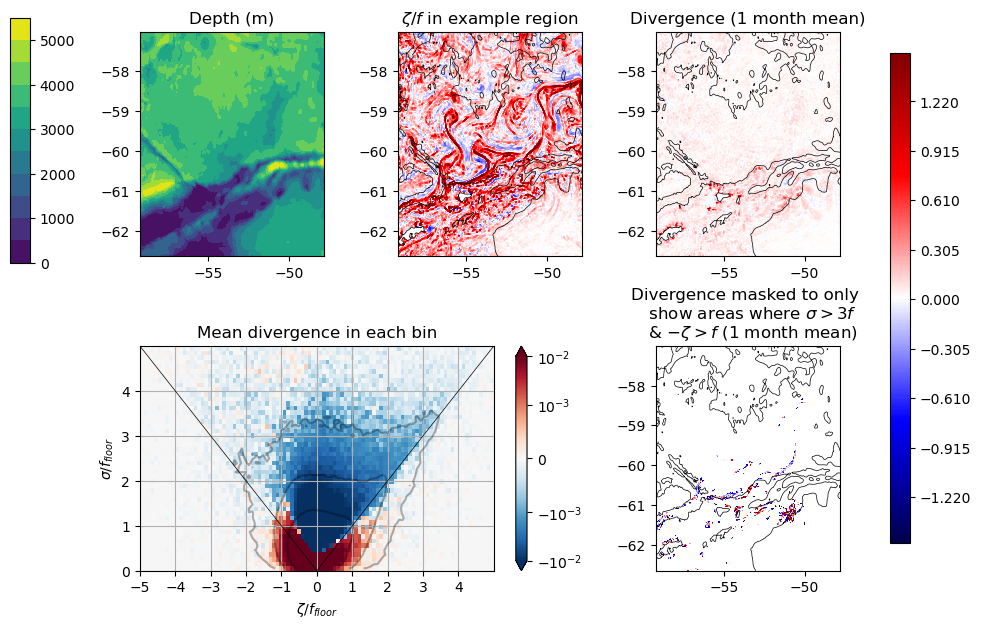

In [72]:
import matplotlib.patches as patches
fig3 = plt.figure(figsize=(10,7))
gs = fig3.add_gridspec(2, 3)



fig3.add_subplot(gs[0, 0])
cs1 = plt.contourf(lon_piece,lat_piece,Depth_piece.transpose().values, levels=np.arange(0,6000,500), cmap='viridis')
plt.colorbar(cs)
plt.title('Depth (m)')

fig3.add_subplot(gs[0, 1])
plt.contourf(lon_piece,lat_piece,ζ_piece.transpose().values, levels=np.arange(-3,3.05,0.01)*0.5, cmap='seismic')
plt.contour(lon_piece,lat_piece,Depth_piece.transpose().values, levels=np.arange(0,6000,2000),colors='k',linewidths=0.5)

#ζ_piece.plot(levels=np.arange(-1,1.05,0.01)*0.5)
plt.title('$\zeta/f$ in example region')
#rect = patches.Rectangle((lon_piece.isel(j=0).values, lat_piece.isel(i=0).values), 4.17, 3.5, linewidth=1, edgecolor='k', facecolor='none')

# Add the patch to the Axes
#plt.gca().add_patch(rect)



fig3.add_subplot(gs[1, 0:2])
h_DivPdf.plot(x='vort_bin', vmax=0.01, norm=mpl.colors.SymLogNorm(1e-3))
h_vort_strain.plot.contour(x='vort_bin',levels=[1e-2, 1e-3, 1e-4], colors='k', alpha=.3)
plt.title('Mean divergence in each bin')
plt.plot(np.linspace(0,5), np.linspace(0,5),color='k',linewidth=0.5)
plt.plot(np.linspace(-5,0), np.linspace(5,0),color='k',linewidth=0.5)

plt.xlabel('$\zeta/f_{floor}$')
plt.ylabel('$\sigma/f_{floor}$')
plt.grid()

x_ticks = np.arange(-5, 5)
y_ticks = np.arange(0, 5)

plt.gca().set_xticks(x_ticks)

plt.gca().set_yticks(y_ticks)


fig3.add_subplot(gs[0, 2])
plt.contourf(lon_piece,lat_piece,D_piece2.mean('time').transpose().values, levels=np.arange(-3,3.05,0.01)*0.5, cmap='bwr')
plt.contour(lon_piece,lat_piece,Depth_piece.transpose().values, levels=np.arange(0,6000,2000),colors='k',linewidths=0.5)
plt.title('Divergence (1 month mean)')

fig3.add_subplot(gs[1, 2])
cs = plt.contourf(lon_piece,lat_piece,D_piece2.where((σ_piece2>3) & (ζ_piece2>1)).mean('time').transpose().values, levels=np.arange(-3,3.05,0.01)*0.5, cmap='seismic')
plt.contour(lon_piece,lat_piece,Depth_piece.transpose().values, levels=np.arange(0,6000,2000),colors='k',linewidths=0.5)
plt.title('Divergence masked to only \n  show areas where $\sigma>3f$ \n  & $-\zeta>f$ (1 month mean)')

plt.subplots_adjust(hspace=0.4, wspace=0.4,right=0.85,left=0.15)
cbar_ax = fig3.add_axes([0.9, 0.15, 0.02, 0.7])
fig3.colorbar(cs, cax=cbar_ax,extend='both')

cbar_ax = fig3.add_axes([0.02, 0.55, 0.02, 0.35])
fig3.colorbar(cs1, cax=cbar_ax)

plt.gcf().savefig('hi-strain-topog.png')
plt.show()

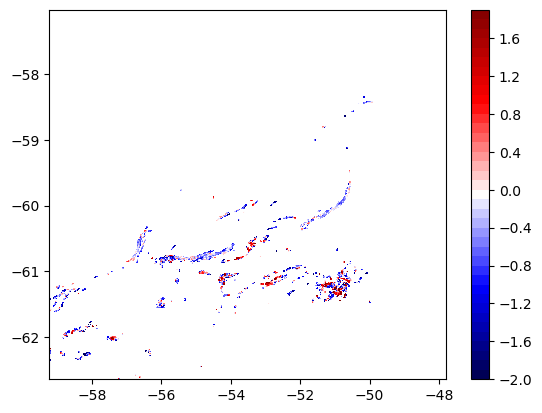

In [65]:
cs = plt.contourf(lon_piece,lat_piece,D_piece2.where((σ_piece2>3) & (ζ_piece2>1)).mean('time').transpose().values,levels=np.arange(-2,2,0.1),cmap='seismic')
plt.colorbar(cs,extend='both')

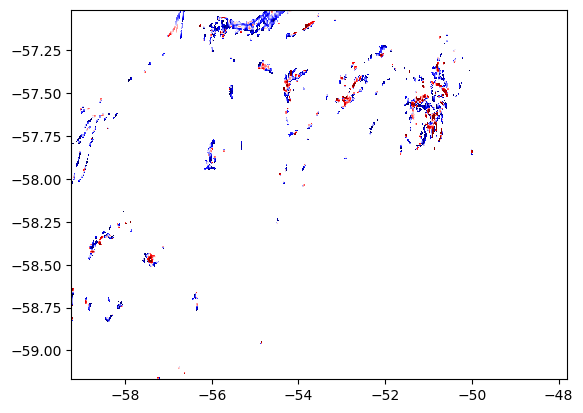

In [71]:
cs = plt.contourf(lon_piece,lat_piece[0:200],D_piece2.where((σ_piece2>3) & (ζ_piece2>1)).mean('time').transpose()[-200:,:].values, levels=np.arange(-3,3.05,0.01)*0.5, cmap='seismic')


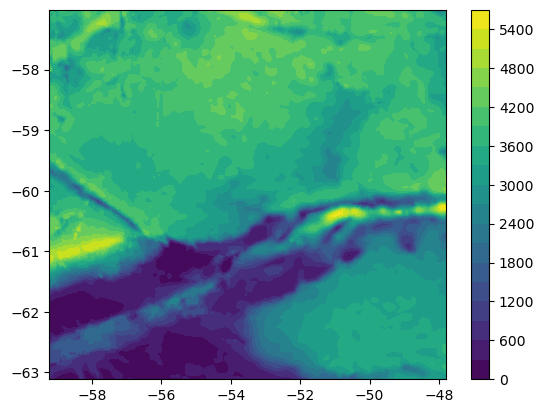

In [61]:
cs = plt.contourf(lon_piece, lat_piece, Depth_piece.transpose().values,levels=20)
plt.colorbar(cs)

In [42]:
lat_piece = ds.sel(face=12).isel(i=slice(0,600)).isel(j=slice(3300,3850)).YC.mean('j')

In [68]:
D_piece2.where((σ_piece2>3) & (ζ_piece2>1)).mean('time').transpose()

<xarray.DataArray (i: 550, j: 550)> Size: 1MB
dask.array<transpose, shape=(550, 550), dtype=float32, chunksize=(550, 550), chunktype=numpy.ndarray>
Coordinates:
    face     int64 8B 12
  * i        (i) int64 4kB 0 1 2 3 4 5 6 7 8 ... 542 543 544 545 546 547 548 549
  * j        (j) int64 4kB 3300 3301 3302 3303 3304 ... 3845 3846 3847 3848 3849

In [41]:
σ_piece3 = σ.isel(time=np.arange(4000-350,4000+350,24)).sel(face=11).isel(i_g=slice(4000,4320)).isel(j_g=slice(3300,3850)).rename({"i_g": "i", "j_g": "j"})/1.25/10**-4
ζ_piece3 = ζ.isel(time=np.arange(4000-350,4000+350,24)).sel(face=11).isel(i_g=slice(4000,4320)).isel(j_g=slice(3300,3850)).rename({"i_g": "i", "j_g": "j"})/1.25/(-10**-4)
D_piece3 = D.isel(time=np.arange(4000-350,4000+350,24)).sel(face=11).isel(i=slice(4000,4320)).isel(j=slice(3300,3850))/1.25/10**-4

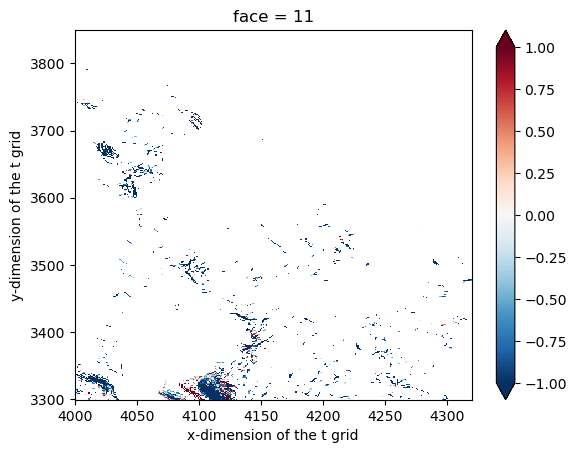

In [42]:
D_piece3.where(σ_piece3>2).mean('time').plot(vmax=1)

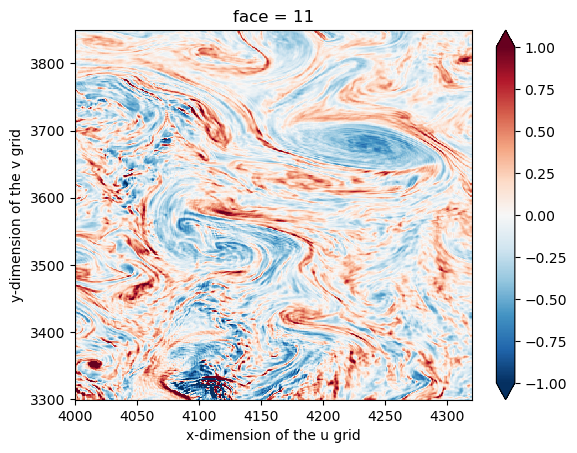

In [64]:
ζ_piece3.isel(time=3).plot(vmax=1)

In [46]:
h = histogram(
    ζ_piece3.rename('vort'),
    σ_piece3.rename('strain'),
    D_piece3.rename('div'),
    bins=[vort_bins, strain_bins, div_bins],
    block_size=None,  # avoids a divide-by-zero bug in xhistogram's code for automatically determining block_size
    density=False,  # setting this to true leads to an error right now
    keep_coords=True,
)
h = h/a/550/550

In [50]:
h_vort_strain = (h.pdf.marginalize('div_bin')/97).load()
h_DivPdf = (h*h.div_bin).mean('div_bin').load()
lat = ds.sel(face=1).YC.mean('i')
lon = ds.sel(face=1).XC.mean('j')

<>:7: SyntaxWarning: invalid escape sequence '\z'
<>:8: SyntaxWarning: invalid escape sequence '\s'
<>:7: SyntaxWarning: invalid escape sequence '\z'
<>:8: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_205/738368629.py:7: SyntaxWarning: invalid escape sequence '\z'
  plt.xlabel('$\zeta/f_{floor}$')
/tmp/ipykernel_205/738368629.py:8: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('$\sigma/f_{floor}$')


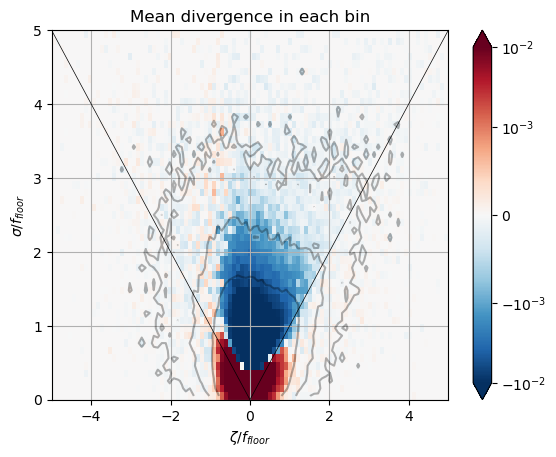

In [51]:
h_DivPdf.plot(x='vort_bin', vmax=0.01, norm=mpl.colors.SymLogNorm(1e-3))
h_vort_strain.plot.contour(x='vort_bin',levels=[1e-3, 1e-4, 1e-5], colors='k', alpha=.3)
plt.title('Mean divergence in each bin')
plt.plot(np.linspace(0,5), np.linspace(0,5),color='k',linewidth=0.5)
plt.plot(np.linspace(-5,0), np.linspace(5,0),color='k',linewidth=0.5)

plt.xlabel('$\zeta/f_{floor}$')
plt.ylabel('$\sigma/f_{floor}$')
plt.grid()

In [52]:
lon_piece3 = ds.sel(face=11).isel(i=slice(4000,4320)).isel(j=slice(3300,3850)).XC.mean('i')
lat_piece3 = ds.sel(face=11).isel(i=slice(4000,4320)).isel(j=slice(3300,3850)).YC.mean('j')

In [58]:
lon_piece3.min().values

array(-59.239582, dtype=float32)

In [59]:
Depth_piece3 = ds.sel(face=11).isel(i_g=slice(4000,4320)).isel(i=slice(4000,4320)).isel(j_g=slice(3300,3850),j=slice(3300,3850)).Depth

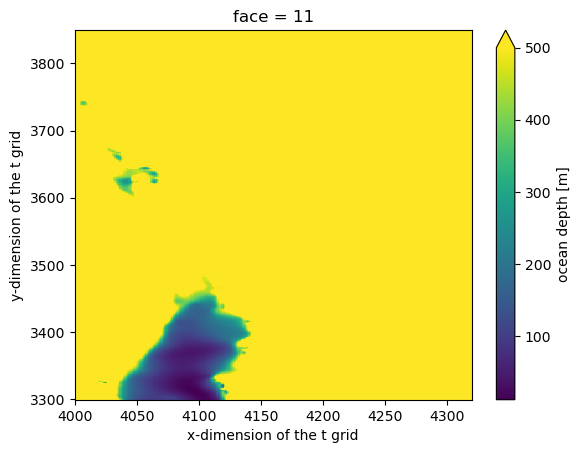

In [62]:
Depth_piece3.plot(vmax=500)